In [1]:
# %load ../../scripts/fold_enrichment.py
import pandas as pd
import numpy as np
import argparse
from collections import defaultdict
from scipy.stats import linregress
from pprint import pprint
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.2, palette='Set2')

In [2]:
#####   Parse Input   #####
out_path = './'

drop_samples = [line.strip() for line in open('./drop.tsv', 'r')]  #[ 'NHP-3-1', 'NHP-3-2']
control_col = 'input'

# pd.DataFrame(index=oligoID, columns=sampleID, values=proportions of reads in each column assigned to each oligo)
proportions = pd.read_csv('./proportions.csv', index_col=0)
counts = pd.read_csv('./2018.01.08.annotatedCounts.csv', index_col=0)
# drop bad replicates or superfluous samples as specified
proportions.drop(drop_samples, inplace=True, axis=1)#, errors='ignore')
counts.drop(drop_samples, inplace=True, axis=1)

# all columns with 'input' in the name
input_cols = [c for c in proportions.columns.values if 'input' in c.lower()]
# all columns with 'beads' in the name
beads_cols = [c for c in proportions.columns.values if 'beads' in c.lower()]

# nonnumerical columns
metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains']
metadata = proportions[metadata_cols]

# all non-metadata columns
proportions = proportions[[c for c in proportions.columns.values if c not in metadata_cols]]
counts = counts[proportions.columns.values]

In [3]:
def aggregate(df, reps, name, inplace=True):
    ''' Pull all the columns indicated in `reps` from the dataframe `df`. 
        If inplace=True, make a new column in the input dataframe with given `name` as the new column header 
        and delete the input `reps` columns.
        Otherwise, just average each row of `reps` and return as a series.'''
    if len(reps) == 1:
        agg = df[reps[0]]
    else:
        agg = df[reps].mean(axis=1) # mean of each row --> new column of aggregated values
    
    if inplace == True:
        df[name] = agg
        df.drop(reps, inplace=True, axis=1, errors='ignore') # drop original columns (yes, the axis designator switches between these two methods which is incredibly annoying but is correct I promise)
    else:
        return agg

In [4]:
## Look at how serum concentration effects sequencing depth

concentration_replicates = defaultdict(list) # { 'DENV1_20ug': ['DENV1_20ug.rep1', 'DENV1_20ug.rep2'] }

for serum in counts.columns.values: # Find replicates 
    if 'ug' in serum or 'ng' in serum:
        name = serum.split('.rep')[0]
        concentration_replicates[name].append(serum)
        
aggregated_concentration_replicates = defaultdict(dict) # { 'DENV1': {'20ug': aggregated values, '10ug': aggregated values}}

for sample_concentration, replicates in concentration_replicates.items(): # aggregate replicates
    sample, concentration = sample_concentration.rsplit('_', 1)
    concentration = int(concentration[:-2])
    agg = aggregate(counts, replicates, sample, inplace=False)
    aggregated_concentration_replicates[sample][concentration] = agg
    
for sample, concentration_aggregated_replicates in aggregated_concentration_replicates.items():
    aggregated_concentration_replicates[sample] = pd.DataFrame(concentration_aggregated_replicates)

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


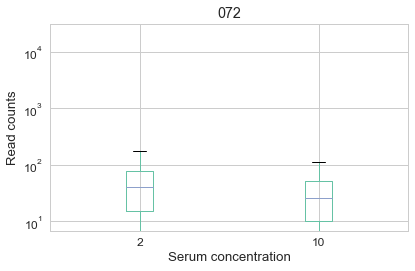

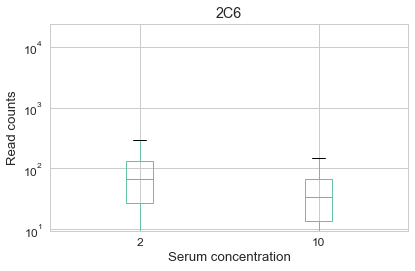

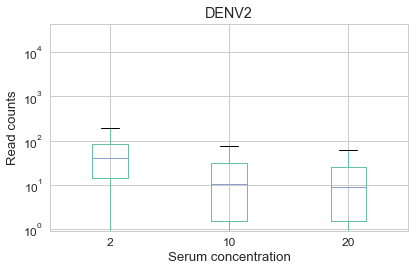

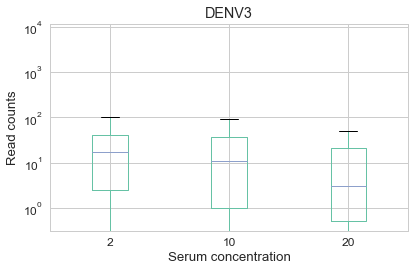

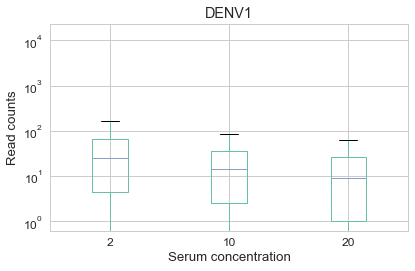

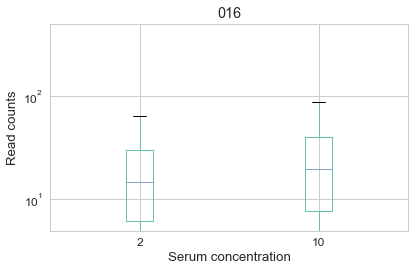

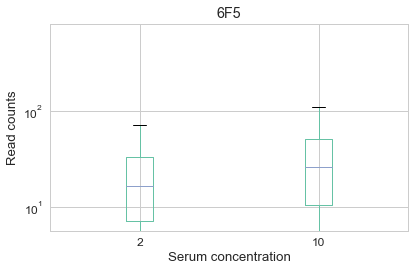

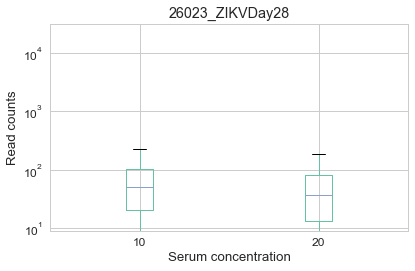

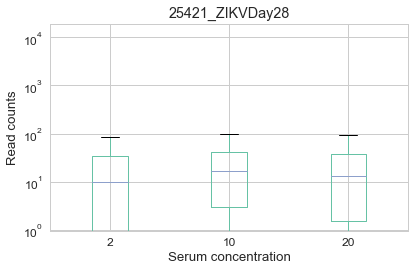

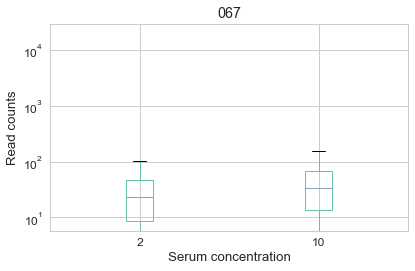

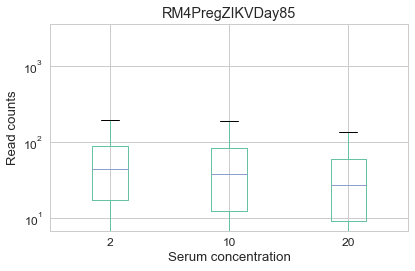

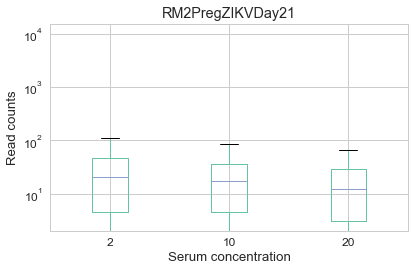

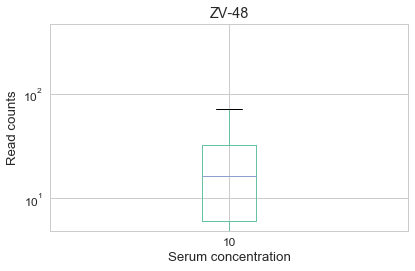

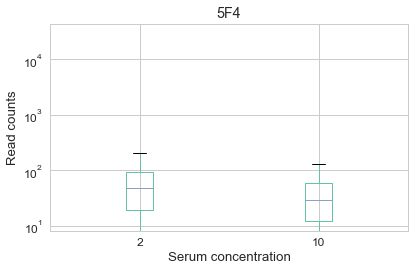

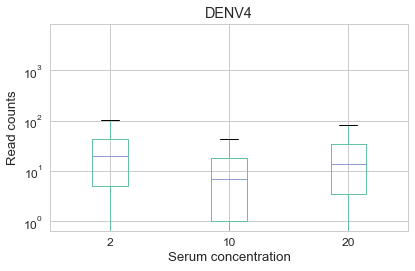

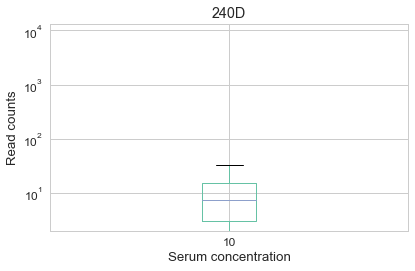

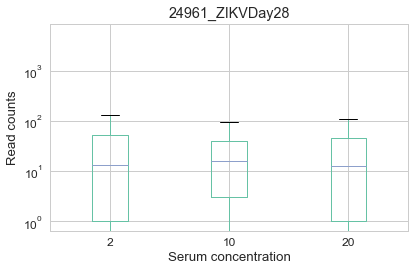

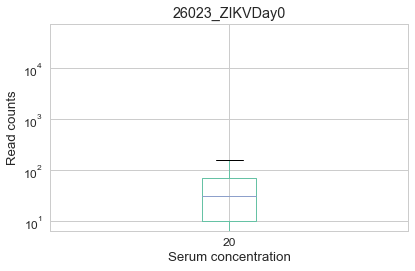

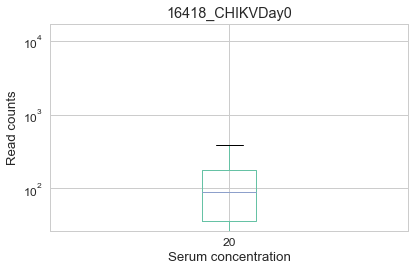

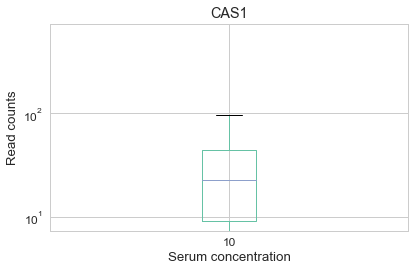

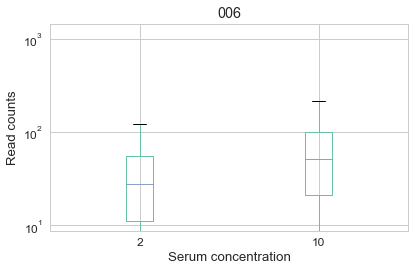

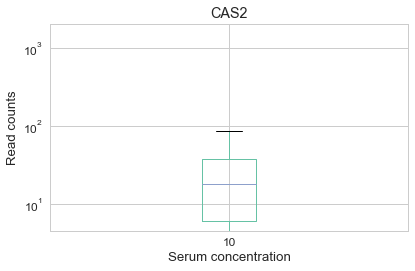

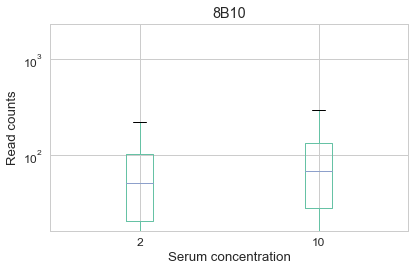

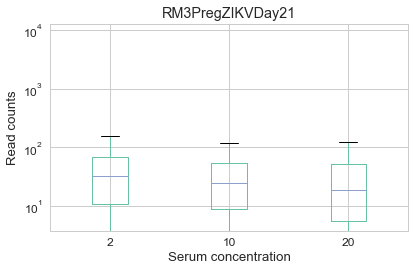

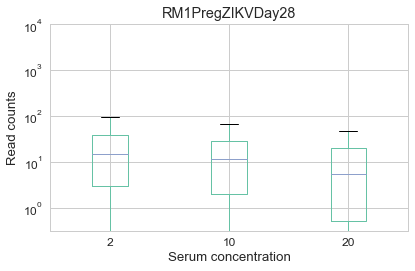

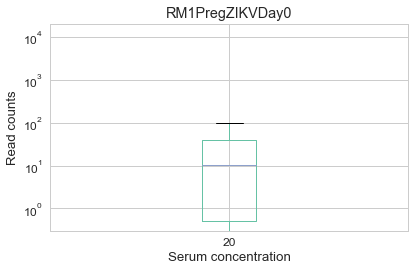

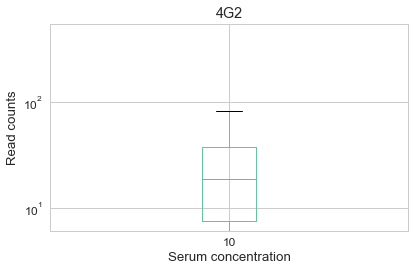

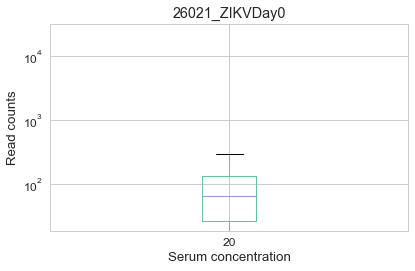

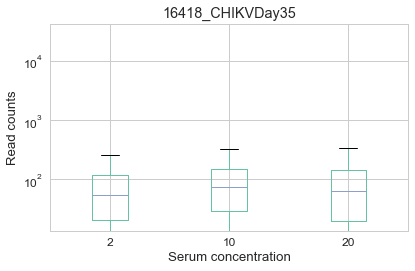

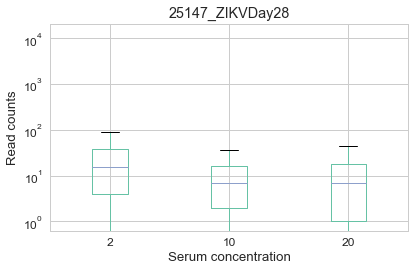

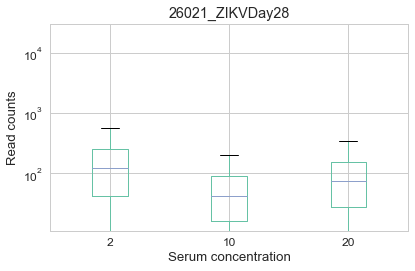

In [5]:
for sample, df in aggregated_concentration_replicates.items():
    ax = df.plot(kind='box', logy=True, sort_columns=True)
    ax.set_title(sample)
    ax.set_xlabel('Serum concentration')
    ax.set_ylabel('Read counts')
    plt.tight_layout()

In [9]:
'''It looks like 2 vs. 10 vs. 20ug doesn't make a huge difference in terms of read coverage.  
However, from the qc analysis, the 2ug samples do have more noise between replicates. 
We have 20ug replicates from more samples, and it's easiest to start comparing apples to apples. 
So, take the 20ug replicates for now'''

selected_samples = ['16418_CHIKVDay0_20ug', '16418_CHIKVDay35_20ug',
                       '24961_ZIKVDay0_20ug', '24961_ZIKVDay28_20ug',
                       '25147_ZIKVDay0_20ug', '25147_ZIKVDay28_20ug',
                       '25421_ZIKVDay0_20ug', '25421_ZIKVDay28_20ug', 
                       '26021_ZIKVDay0_20ug', '26021_ZIKVDay28_20ug',
                       '26023_ZIKVDay0_20ug', '26023_ZIKVDay28_20ug',
                       'RM1PregZIKVDay0_20ug', 'RM1PregZIKVDay28_20ug',
                       'RM2PregZIKVDay21_20ug', 'RM3PregZIKVDay21_20ug', 
                       'RM4PregZIKVDay85_20ug', 
                        'DENV1_20ug', 'DENV2_20ug', 'DENV3_20ug', 'DENV4_20ug']


technical_replicates = defaultdict(list) # { 'input': ['Input1', 'Input2'], 
                                         #  'DENV3_20ug': ['DENV3_20ug.rep1', DENV3_20ug.rep2'] }
for serum in proportions.columns.values:
    if serum in beads_cols:
        name = 'beads'
        technical_replicates[name].append(serum)
    elif serum in input_cols:
        name = 'input'
        technical_replicates[name].append(serum)
    else:
        name = serum.rsplit('.', 1)[0]
        if name in selected_samples:
            technical_replicates[name].append(serum)
        else:
            continue

In [10]:
aggregated_technical_replicates = { serum: aggregate(proportions, reps, serum, inplace=False) 
                                    for serum, reps in technical_replicates.items()}

aggregated_technical_replicates = pd.DataFrame(aggregated_technical_replicates)

# now data looks like pd.DataFrame(columns=['NHP-1', 'input', 'beads', 'NHP-2', ...])

In [11]:
print aggregated_technical_replicates.head()

                16418_CHIKVDay0_20ug  16418_CHIKVDay35_20ug  \
id                                                            
1                           0.000707               0.000572   
100                         0.000199               0.000101   
1001                        0.000131               0.000035   
1002                        0.000301               0.000170   
1008.1177.1346              0.001542               0.001197   

                24961_ZIKVDay28_20ug  25147_ZIKVDay28_20ug  \
id                                                           
1                           0.000331              0.000380   
100                         0.000043              0.000141   
1001                        0.000000              0.000053   
1002                        0.000385              0.000147   
1008.1177.1346              0.000926              0.001212   

                25421_ZIKVDay28_20ug  26021_ZIKVDay0_20ug  \
id                                                          
1

In [15]:
#####   Convert all values to fold enrichment over control  #####
mean_control_val = aggregated_technical_replicates[control_col].mean() # avoid dividing by 0
filled_control_col = aggregated_technical_replicates[control_col].replace(0., mean_control_val)
enrichment = aggregated_technical_replicates.divide(filled_control_col, axis=0)

annotated_enrichment = enrichment.join(metadata) # reattach the metadata
annotated_enrichment.to_csv(out_path+'enrichment.csv') # write to file

In [16]:
print annotated_enrichment.head()

                16418_CHIKVDay0_20ug  16418_CHIKVDay35_20ug  \
id                                                            
1                           0.664517               0.537128   
100                         0.925310               0.468594   
1001                        0.734245               0.197732   
1002                        2.405997               1.363379   
1008.1177.1346              0.640381               0.497251   

                24961_ZIKVDay28_20ug  25147_ZIKVDay28_20ug  \
id                                                           
1                           0.310872              0.357264   
100                         0.199741              0.657030   
1001                        0.000000              0.295953   
1002                        3.077846              1.176111   
1008.1177.1346              0.384816              0.503280   

                25421_ZIKVDay28_20ug  26021_ZIKVDay0_20ug  \
id                                                          
1

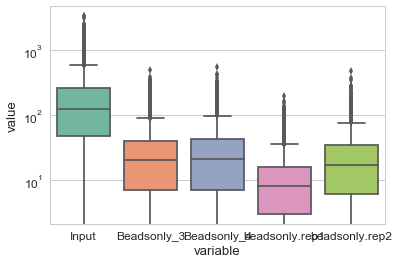

In [5]:
ctrl_cols = input_cols + beads_cols
ctrl_counts = counts[ctrl_cols]
ctrl_counts = ctrl_counts.melt()
plt.yscale('log')
sns.boxplot(x='variable', y='value', data=ctrl_counts)

In [13]:
time_series = defaultdict(list)

for sample in aggregated_technical_replicates.columns.values:
    if 'Day' not in sample:
        continue
    ID = sample.split('Day')[0]
    time_series[ID].append(sample)
    
time_series = {k:v for k,v in time_series.items() if len(v) > 1}

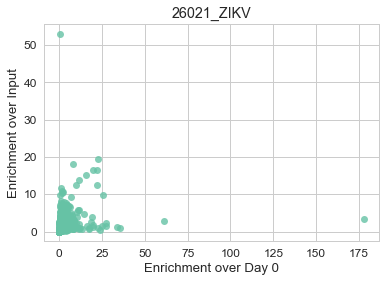

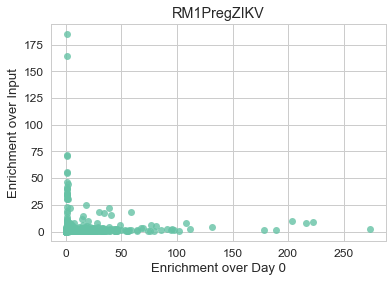

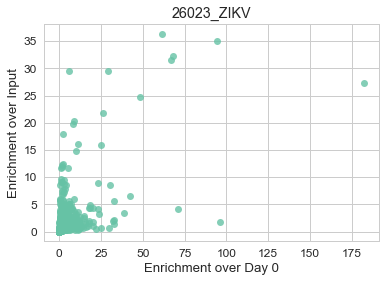

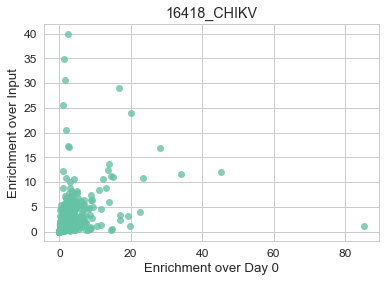

In [35]:
def get_r_2(x_series, y_series):
    x = x_series.values
    y = y_series.values
    
    valid = ~np.isnan(x) & ~np.isnan(y)
    r_2 = linregress(x[valid], y[valid])
    print r_2
    return r_2

for sample, timepoints in time_series.items():
    timepoints.sort()
    baseline = aggregated_technical_replicates[timepoints[0]]
    compare = aggregated_technical_replicates[timepoints[1]]
    input_vals = aggregated_technical_replicates['input']
    
    self_norm_enrichment = compare.divide(baseline)
    input_enrichment = compare.divide(input_vals)
    ax = sns.regplot(x=self_norm_enrichment, y=input_enrichment)
    
#     r_2 = get_r_2(self_norm_enrichment, input_enrichment)
    
#     plt.text(1,1, 'R^2 = %.2f'%(r_2))
    ax.set_xlabel('Enrichment over Day 0')
    ax.set_ylabel('Enrichment over Input')
    ax.set_title(sample)
    plt.show()
    plt.clf()